In [1]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
le = joblib.load("fertilizer_classification/le_classes.pkl")

In [3]:
train = pd.read_csv("fertilizer_classification/fertilizer_train.csv")
test = pd.read_csv("fertilizer_classification/fertilizer_test.csv")
train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler, LabelEncoder
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from sklearn.metrics import roc_curve, precision_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb

import time

set_config(transform_output="pandas")


In [5]:
train.head()
X = train.drop(["Fertilizer Name"], axis = 1)
y = train["Fertilizer Name"]

In [6]:
RandomStateNumber = 13
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state= RandomStateNumber, stratify= y)

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# Load model

In [7]:
# Feature engineering: add Power (W) feature in the data
def feature_engineer(df):
    df = df.copy()
    df["temp_humidity"] = df["Temparature"] * df["Humidity"]
    df["temp_moisture"] = df["Temparature"] * df["Moisture"]
    df["humidity_moisture"] = df["Humidity"] * df["Moisture"]
    df["NPK"] = df["Nitrogen"] + df["Potassium"] + df["Phosphorous"]
    df["Nitrogen_ratio"] = df["Nitrogen"] / df["NPK"]
    df["Potassium_ratio"] = df["Potassium"] / df["NPK"]
    df["Phosphorous_ratio"] = df["Phosphorous"] / df["NPK"]

    return df

In [8]:
feature_transformer = FunctionTransformer(feature_engineer)

numeric_features = [
    "Temparature", "Humidity", "Moisture",
    "Nitrogen", "Potassium", "Phosphorous",
    # "temp_humidity", "temp_moisture", "humidity_moisture",
    # "Nitrogen_ratio", "Potassium_ratio", "Phosphorous_ratio"
]

categorical_features = [
    "Soil Type", "Crop Type"
]

# Column Transformer for the different transformation
numericColumns = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numeric_features),
    ],
    remainder = "passthrough",
    verbose_feature_names_out= False
)


transformColumns = ColumnTransformer(
    transformers =[
        ('num', MinMaxScaler(), numeric_features),
         ('cat', OneHotEncoder(sparse_output= False), categorical_features)
         ],
    verbose_feature_names_out= False)

chartprocessing = Pipeline(
    [
        # ('feature_engineering', feature_transformer),
        ('numeric_Columns', numericColumns)
        ]
    )

preprocessing = Pipeline(
    [
        # ('feature_engineering', feature_transformer),
        ('transformColumns', transformColumns)
        ]
    )

# # Create pipeline
pipe = Pipeline([
    ('classifier', RandomForestClassifier(random_state= RandomStateNumber)) # Placeholder model
    ,
])

In [9]:
# preprocess train & test data
X_train_scaled = preprocessing.fit_transform(X_train)
X_val_scaled = preprocessing.transform(X_val)

In [21]:
joblib.dump(preprocessing, "fertilizer_classification/preprocessing.pkl")

['fertilizer_classification/preprocessing.pkl']

In [10]:
model = joblib.load("fertilizer_classification/best_model.pkl")

In [11]:
y_pred_proba = model.predict_proba(X_val_scaled)
y_pred_proba

array([[0.14202543, 0.12356766, 0.0934531 , ..., 0.14093831, 0.21082775,
        0.17844683],
       [0.1457367 , 0.16352901, 0.13794495, ..., 0.17710036, 0.07115735,
        0.14060292],
       [0.11128339, 0.15101027, 0.11641679, ..., 0.1451908 , 0.21736462,
        0.08967067],
       ...,
       [0.19479874, 0.15540665, 0.13986972, ..., 0.15536086, 0.05813794,
        0.13152231],
       [0.15444577, 0.19954215, 0.11653207, ..., 0.14444254, 0.08915234,
        0.17400561],
       [0.10392946, 0.15917908, 0.0964719 , ..., 0.21061732, 0.0913021 ,
        0.16101411]], dtype=float32)

In [12]:
top3_indices_test = np.argsort(y_pred_proba, axis=1)[:, -3:][:, ::-1]
predictTable = pd.DataFrame()
predictTable["y_pred_proba"] = list(top3_indices_test)
predictTable["y_val"] = y_val
predictTable

,y_pred_proba,y_val
0,"[5, 6, 0]",0
1,"[4, 3, 1]",2
2,"[5, 3, 1]",4
3,"[1, 2, 3]",5
4,"[4, 5, 1]",6
...,...,...
149995,"[1, 3, 4]",0
149996,"[5, 1, 6]",1
149997,"[0, 3, 1]",5
149998,"[1, 6, 0]",2


In [13]:
predictTable["y_pred"] = predictTable.apply(
    lambda row: (
        row["y_val"] if row["y_val"] in row["y_pred_proba"]
        else row["y_pred_proba"][0]  # returns the first item if False
    ),
    axis=1
)
predictTable["y_pred"].astype(int)
print(classification_report(predictTable["y_val"],predictTable["y_pred"], target_names=le.classes_))


              precision    recall  f1-score   support

    10-26-26       0.52      0.59      0.55     22777
    14-35-14       0.51      0.60      0.55     22887
    17-17-17       0.52      0.58      0.55     22491
       20-20       0.52      0.54      0.53     22178
       28-28       0.52      0.55      0.54     22232
         DAP       0.53      0.40      0.45     18972
        Urea       0.55      0.34      0.42     18463

    accuracy                           0.52    150000
   macro avg       0.53      0.51      0.51    150000
weighted avg       0.52      0.52      0.52    150000



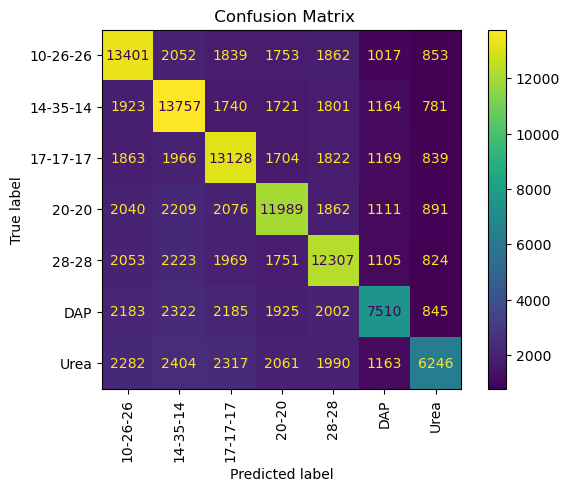

In [14]:
cm = confusion_matrix(predictTable["y_val"],predictTable["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot()
plt.title(f" Confusion Matrix")
plt.xticks(rotation = 90)
plt.show()

In [15]:
accuracy_score(predictTable["y_val"],predictTable["y_pred"])

0.5222533333333333

In [16]:
predictTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   y_pred_proba  150000 non-null  object
 1   y_val         150000 non-null  int64 
 2   y_pred        150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [17]:
predictTable["top3"] = list(le.classes_[top3_indices_test])

Crop Type_Pulses         0.053381
Phosphorous              0.051038
Nitrogen                 0.049878
Crop Type_Sugarcane      0.049644
Moisture                 0.049449
Potassium                0.048325
Soil Type_Sandy          0.047561
Temparature              0.045592
Humidity                 0.045557
Crop Type_Paddy          0.045406
Soil Type_Clayey         0.045384
Soil Type_Loamy          0.045061
Soil Type_Red            0.044527
Soil Type_Black          0.044260
Crop Type_Wheat          0.042833
Crop Type_Ground Nuts    0.042730
Crop Type_Cotton         0.042666
Crop Type_Tobacco        0.042563
Crop Type_Oil seeds      0.041661
Crop Type_Millets        0.041118
Crop Type_Barley         0.040836
Crop Type_Maize          0.040531
dtype: float32


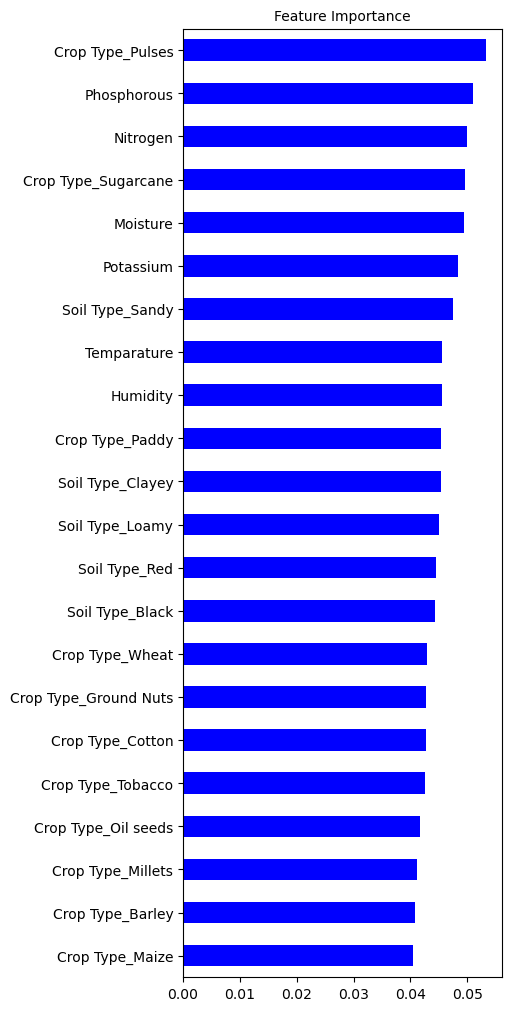

In [18]:


importance = model.feature_importances_
columns = X_train_scaled.columns
coeff = pd.Series(importance, columns)
print(coeff.sort_values(ascending = False))

fig = plt.figure(figsize=(5,10), layout = "constrained")

coeff.sort_values(ascending = True).plot.barh(color="blue")
plt.title("Feature Importance", fontsize=10)
plt.show()

In [19]:
predictTable

,y_pred_proba,y_val,y_pred,top3
0,"[5, 6, 0]",0,0,"[DAP, Urea, 10-26-26]"
1,"[4, 3, 1]",2,4,"[28-28, 20-20, 14-35-14]"
2,"[5, 3, 1]",4,5,"[DAP, 20-20, 14-35-14]"
3,"[1, 2, 3]",5,1,"[14-35-14, 17-17-17, 20-20]"
4,"[4, 5, 1]",6,4,"[28-28, DAP, 14-35-14]"
...,...,...,...,...
149995,"[1, 3, 4]",0,1,"[14-35-14, 20-20, 28-28]"
149996,"[5, 1, 6]",1,1,"[DAP, 14-35-14, Urea]"
149997,"[0, 3, 1]",5,0,"[10-26-26, 20-20, 14-35-14]"
149998,"[1, 6, 0]",2,1,"[14-35-14, Urea, 10-26-26]"


In [20]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)>